In [1]:
from matplotlib import pylab
import nengo
import numpy as np

%matplotlib inline

In [2]:
STEP = 0.001#s
EQ_MARGIN = 0.0001
SIM_TIME = 500#s
SWITCH_TIME = 0.500#s
SWITCH_TIME2 = 0.050#s
CHECKS = 45
DIVIDER = 1
SIM_TIME2 = SWITCH_TIME2#s
def fn(j, vals, vals2, vals3):
    s = SWITCH_TIME
    vs = vals
#    cur = STEP
    i = 0
    #prep yield
    t = yield
    init = t
    cur = init
    #print t
    while True:
    #initial training
        if -EQ_MARGIN <= t-SIM_TIME-init <= EQ_MARGIN:
            break
        if -EQ_MARGIN <= t-cur-s <= EQ_MARGIN:
            #print '*********************************************'
            cur = t
            i += 1
        t = yield [vs[i], 0, 1]
        #print cur, t, t-cur, s, t-cur-s, -EQ_MARGIN <= t-cur-s <= EQ_MARGIN
        j.append(vs[i])
    s = SWITCH_TIME2
    vs = vals2
    cur = t
    i = 0
    while True:
    #assessment 1
        if i >= len(vals2):
            print 'too far', t
            break
        t = yield [vs[i], 0, 0]
        j.append(vs[i])
        if -EQ_MARGIN <= t-cur-s <= EQ_MARGIN:
            cur = t
            i += 1
    s = SWITCH_TIME
    vs = vals3
    cur = t
    resim_time = SIM_TIME/DIVIDER+t
    i = 0
    while True:
    #retraining
        if -EQ_MARGIN <= t-resim_time <= EQ_MARGIN:
            break
        if -EQ_MARGIN <= t-cur-s <= EQ_MARGIN:
            cur = t
            i += 1
        t = yield [vs[i], 1, 0.5]
        j.append(vs[i])
    s = SWITCH_TIME2
    vs = vals2
    cur = t
    i = 0
    while True:
    #assessment 2
        if i >= len(vals2):
            print 'too far', t
            break
        t = yield [vs[i], 0, 0]
        j.append(vs[i])
        if -EQ_MARGIN <= t-cur-s <= EQ_MARGIN:
            cur = t
            i += 1
    while True:
        t = yield [0, 0, 0]

In [3]:
model = nengo.Network(seed=3)
dist = nengo.dists.Uniform(-1.0, 1.0)
vals = dist.sample((SIM_TIME/SWITCH_TIME)+1)
vals3 = dist.sample((SIM_TIME/SWITCH_TIME/DIVIDER)+1)
vals2 = np.linspace(-1, 1, CHECKS)
j=[]
func = fn(j, vals, vals2, vals3)
func.next()
func = func.send

In [4]:
#time = int(2*((SIM_TIME/STEP)+(CHECKS*SWITCH_TIME2/STEP)))
#print time
#a = [func(0.001*x) for x in range(1, time+1)]

In [5]:
#b = np.array(a)
#c = b[:, 0]
#print list(c).index(-1.0)
#print c[49999+2200:49999+2250]

In [6]:
#d = {}
#z=52200
#for a in set(c[:]):
#    d[a] = 0
#for a in c[:]:
#    d[a] += 1
#for k in d:
#    if d[k] != 500 and d[k] != 1000 and d[k] != 50 and d[k] != 100:
#        print k, d[k]
#print c[0], c[499], c[500], c[999], c[1000], c[1499]
#print c[49998], c[49999]
#print c[3501], c[4001], c[1500], c[2000], c[2001]
#print c[52200-1:52250]
#print [i for i, x in enumerate(c[:z]) if -0.01 < x+0.421665933532 < 0.01]

In [7]:
with model:
    stim = nengo.Node(func)
    
    sensory = nengo.Ensemble(n_neurons=400, dimensions=3,
                            intercepts=nengo.dists.Uniform(0.81,0.91))
    
    
    spatial = nengo.Ensemble(n_neurons=400, dimensions=2,
                            intercepts=nengo.dists.Uniform(0.81,0.91))
    
    nengo.Connection(stim, sensory[:],
                     function=lambda x: (np.sin(x[0]*np.pi/2), 
                                         np.cos(x[0]*np.pi/2), 
                                         x[1]))
    
    #nengo.Connection(sensory[:2], sensory[2:], synapse=0.2)
    
    c = nengo.Connection(sensory, spatial, function=lambda x: [0,0],
                         learning_rule_type=nengo.PES(learning_rate=3e-4))
        
    error = nengo.Ensemble(n_neurons=400, dimensions=3)
    
    nengo.Connection(stim[2], error[2])
    nengo.Connection(sensory[:2], error[:2],
                     transform=-1)
    nengo.Connection(error, c.learning_rule, 
                     #0.19 is 17deg shift (need more negative to mitigate it)
                     function=lambda x: x[:2] if x[2] > 0.7 else x[:2]-0.19 if x[2] > 0.3 else [0, 0])
    #nengo.Connection(spatial, c.learning_rule, synapse=0.1)
    
    nengo.Connection(spatial, error[:2])
    #correct = nengo.Node([0,0])
    #nengo.Connection(correct, error, transform=-1)
    
    spatial_probe = nengo.Probe(spatial.neurons)
    


In [8]:
sim = nengo.Simulator(model)
sim.run(SIM_TIME)

Simulation finished in 0:03:11.                                                 


In [9]:
def sim_gen(time, cnt):
    cur = 0
    yield np.mean(sim.data[spatial_probe][-int(SWITCH_TIME2/STEP):], axis=0) #prep
    while cur <= cnt:
        sim.run(time, progress_bar=False)
        yield np.mean(sim.data[spatial_probe][-int(SWITCH_TIME2/STEP):], axis=0)
        #print sim.data[spatial_probe].shape
        cur += 1
        
def calc_norm(rates, rate_peaks=None):
    #assume that cells with similar peak centers would fall under the same
    #multicellular recording therefore peaks are done relative to all values with similar peaks
    nrm_rates = []
    if rate_peaks is None:
        rate_peaks = np.max(rates, axis=1)
        rate_peaks = np.array([p if p > 0 else 1 for p in rate_peaks])
    max_i = np.argmax(rates, axis=0)
    for j, i in enumerate(max_i):
        nrm_rates.append(rates[:, j]/rate_peaks[i])
    nrm_rates = np.array(nrm_rates).transpose()
    return nrm_rates, rate_peaks

def align_cut(nrm, dist, num_checks, maxes=None):
    #below uses the protocol from the paper where the center value of the values with >= 50% of
    #the max value is used as the max
    #cut assumes that it is not multimodal
    if maxes is None:
        cut = [[(i, neuron_val) for i, neuron_val in enumerate(nrm[:, col]) 
                if neuron_val >= 0.5] for col in range(nrm.shape[1])]
        maxes = [(i, neuron_vals[len(neuron_vals)/2][0]) 
                 for i, neuron_vals in enumerate(cut) 
                 if len(neuron_vals) > 0]
    max_cuts = [nrm[mx-dist:mx+dist+1, i] 
                for i, mx in maxes 
                if mx >= dist and mx <= num_checks-(dist+1)]
    return np.array(max_cuts), maxes

def prep_graph(time, cnt, dist):
    sim_g = sim_gen(time, cnt)
    sim_g.next()
    return align_cut(calc_norm(np.array([mean for mean in sim_g])), dist)

def graph_neurons(vals, step):
    for v in range(vals.shape[0]):
        pylab.plot(range(-DIST*step, DIST*step+1, step), vals[v, :])

def graph_mean(mean, step):
    pylab.plot(range(-DIST*step, DIST*step+1, step), mean)
    
def filtered_mean(vals):
    return np.mean([x for x in vals if sum(x) > 0], axis=0)

In [10]:
sim_g = sim_gen(SIM_TIME2, len(vals2)-1)
a=sim_g.next()
#print a.shape
mean = np.array([mean for mean in sim_g])
print mean.shape
Y = len(j)
print Y

too far 502.25
(45, 400)
502250


In [11]:
n, rate_peaks = calc_norm(mean)

In [12]:
DIST = 10
D_STEP = 10
out, maxes = align_cut(n, DIST, len(vals2))
print out.shape
print [len(x) for x in out]
mean_out = np.mean(out, axis=0)
print mean_out.shape

(115, 21)
[21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
(21,)


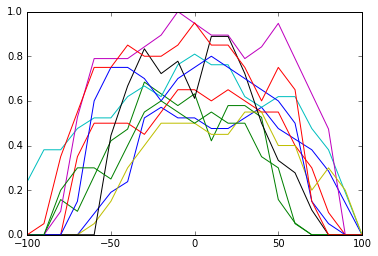

In [13]:
graph_neurons(out[:10], D_STEP)

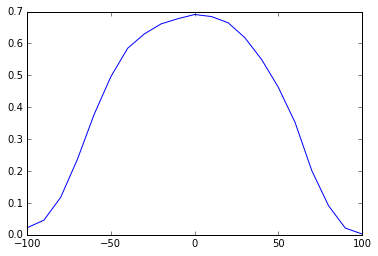

In [14]:
graph_mean(mean_out, D_STEP)

In [15]:
sim.run(SIM_TIME/DIVIDER)

Simulation finished in 0:03:20.                                                 


In [16]:
sim_g = sim_gen(SIM_TIME2, len(vals2)-1)
a2=sim_g.next()
#print a.shape
mean2 = np.array([mean for mean in sim_g])
print mean2.shape

too far 1004.5
(45, 400)


In [17]:
n2, rate_peaks2 = calc_norm(mean2)

In [18]:
#Centered the graphs relative to themselves
out2, maxes2 = align_cut(n2, DIST, len(vals2))
print out2.shape
print [len(x) for x in out2]
mean_out2 = filtered_mean(out2)
print mean_out2.shape

(189, 21)
[21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
(21,)


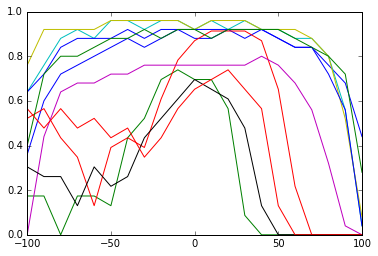

In [19]:
graph_neurons(out2[:10], D_STEP)

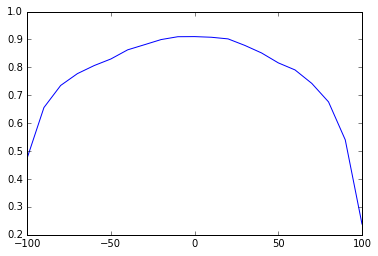

In [20]:
graph_mean(mean_out2, D_STEP)

In [21]:
n3, rate_peaks2 = calc_norm(mean2)

In [22]:
#Centered the graphs relative to the original distribution
out3, maxes3 = align_cut(n3, DIST, len(vals2), maxes)
print out3.shape
print [len(x) for x in out3]
mean_out3 = filtered_mean(out3)
print np.mean([x for x in out3 if sum(x) > 0], axis=1)
print np.sum([x for x in out3 if sum(x) > 0], axis=1)
print mean_out3.shape

(115, 21)
[21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
[ 0.48952381  0.86095238  0.64571429  0.46857143  0.88761905  0.8152381
  0.67619048  0.6552381   0.71238095  0.79809524  0.71809524  0.75047619
  0.67047619  0.63809524  0.44190476  0.78095238  0.66071429  0.79238095
  0.6952381   0.83619048  0.86666667  0.44        0.6         0.91619048
  0.72190476  0.32952381  0.77333333  0.52190476  0.90857143  0.84952381
  0.88380952  0.56150794  0.66285714  0.67047619  0.6952381   0.48
  0.76952381  0.64285714  0.86095238  0.63809524  0.45904762  0.54857143
  0.65333333  0.71619048 

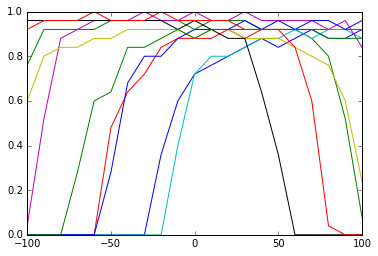

In [23]:
graph_neurons(out3[:10], D_STEP)

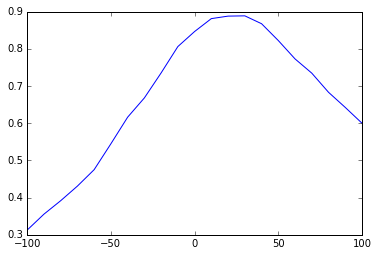

In [24]:
graph_mean(mean_out3, D_STEP)

In [25]:
print len(j)
y = 52250
x = j[y:].index(-1.0)
print x+y
#print j[x:x+10]
d = {}
for a in set(j[:]):
    d[a] = 0
for a in j[:]:
    d[a] += 1
for k in d:
    if d[k] != 500 and d[k] != 1000 and d[k] != 50 and d[k] != 100:
        print k, d[k]
print j[y-55:][:10]
print j[0]
print j[-1]
print sim.data[spatial_probe].shape

1004500
500000
[0.21622291429152973, 0.21622291429152973, 0.21622291429152973, 0.21622291429152973, 0.21622291429152973, 0.21622291429152973, 0.21622291429152973, 0.21622291429152973, 0.21622291429152973, 0.21622291429152973]
0.311497657166
1.0
(1004500, 400)


In [26]:
print len(j)
print j[-2260:-2240]
print j[-1]
print n2.shape
print np.sum(n2, axis=1)
print np.sum(n2, axis=0)
print n2[:, 2]

1004500
[-0.73103092263340952, -0.73103092263340952, -0.73103092263340952, -0.73103092263340952, -0.73103092263340952, -0.73103092263340952, -0.73103092263340952, -0.73103092263340952, -0.73103092263340952, -0.73103092263340952, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]
1.0
(45, 400)
[  56.79487389   47.56494448   54.80561829   53.08655656   61.43644833
   61.11602202   57.65444193   41.57135328   43.06079428   59.6463674
   61.27944946   66.26889893   78.33374082   88.50785244   92.60326652
   89.95690382  103.51831357  116.54326087  122.66586957  126.9326087
  133.94710145  140.60333333  143.945       146.43        148.19333333
  149.54666667  151.95666667  152.53666667  150.11666667  146.06166667
  138.72        128.39        121.48833333  109.86869565  101.67841238
  100.61225296   92.71915679   83.39137681   81.53414361   80.85700922
   78.67250329   67.63247694   72.954361     57.18550066   47.70274045]
[  9.33333333  16.56        12.96         6.26086957  10.56